In [256]:
import pandas as pd
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
import seaborn as sns

In [258]:
DATA_DIR = "eval_results_cf_v6"

In [259]:
df = pd.read_feather(f"{DATA_DIR}/cf_eval_data_8langs.feather")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59703385 entries, 0 to 59703384
Data columns (total 9 columns):
 #   Column        Dtype   
---  ------        -----   
 0   doc_pos       int16   
 1   surprisal     float32 
 2   token         object  
 3   document_len  int16   
 4   document_id   int16   
 5   language      object  
 6   variant       category
 7   sentence_id   int16   
 8   sentence_pos  int16   
dtypes: category(1), float32(1), int16(5), object(2)
memory usage: 1.7+ GB


In [260]:
df["sentence_len"] = (df.groupby(["language", "variant", "document_id", "sentence_id"])
                      .sentence_id.transform("count")
                      .astype("int16"))
df

,doc_pos,surprisal,token,document_len,document_id,language,variant,sentence_id,sentence_pos,sentence_len
0,0,16.772898,vogelart,384,0,de,Min-DL-Opt,0,0,35
1,1,0.443028,die,384,0,de,Min-DL-Opt,0,1,35
2,2,8.020885,wurde,384,0,de,Min-DL-Opt,0,2,35
3,3,6.804230,früher,384,0,de,Min-DL-Opt,0,3,35
4,4,7.709851,genannt,384,0,de,Min-DL-Opt,0,4,35
...,...,...,...,...,...,...,...,...,...,...
59703380,477,0.314286,công,488,2077,vi,Sort-Freq-Rev,16,4,9
59703381,478,0.543610,đó,488,2077,vi,Sort-Freq-Rev,16,5,9
59703382,479,1.987729,được,488,2077,vi,Sort-Freq-Rev,16,6,9
59703383,480,3.708267,và,488,2077,vi,Sort-Freq-Rev,16,7,9


# Datatype Optimization
This code helps save space by saving columns using more efficient datatypes.

In [262]:
# df.doc_pos = df.doc_pos.astype("int16")
# df.document_len = df.document_len.astype("int16")
# df.document_id = df.document_id.astype("int16")
# df.language = df.language.astype("category")
# df.variant = df.variant.astype("category")
# df.sentence_id = df.sentence_id.astype("int16")
# df.sentence_pos = df.sentence_pos.astype("int16")
# df.surprisal = df.surprisal.astype("float32")
# df = df.drop("index", axis=1)
# df.info()
# df.to_feather("eval_results_cf_v5/cf_eval_data_8langs.feather")

# Surprisal

In [264]:
# get the average surprisal for each language-variant combination

surprisals = (
    df.groupby(["language", "variant"])
    .agg({"surprisal": [np.mean, sem, np.std]})
    .reset_index()
)
surprisals.columns = surprisals.columns.get_level_values(0) +  surprisals.columns.get_level_values(1)
surprisals.to_csv(f"{DATA_DIR}/surprisal_plot_vals.csv", index=False)
surprisals

,language,variant,surprisalmean,surprisalsem,surprisalstd
0,de,Approx,5.226449,0.006067,4.952134
1,de,Efficient-OV,5.355264,0.006573,5.365651
2,de,Efficient-VO,5.314713,0.006355,5.187441
3,de,FREQ_OPT,5.446449,0.006136,5.008824
4,de,Min-DL-Loc,5.615842,0.006309,5.149977
...,...,...,...,...,...
91,vi,Random-2,4.905780,0.005787,4.098278
92,vi,Real,3.779203,0.005775,4.089287
93,vi,Reverse,3.844491,0.005964,4.223469
94,vi,Sort-Freq,3.666604,0.005170,3.661348


# Surprisal Variance

In [265]:
surprisal_variances = (
    df.groupby(["language", "variant", "document_id", "sentence_id"])
    .surprisal
    .agg(np.var)
    .dropna()
    .reset_index()
    .groupby(["language", "variant"])
    .agg({"surprisal": [np.mean, sem, np.std]})
    .reset_index()
)
surprisal_variances.columns = surprisal_variances.columns.get_level_values(0) + surprisal_variances.columns.get_level_values(1)
surprisal_variances.to_csv(f"{DATA_DIR}/surprisal_variance_plot_vals.csv", index=False)
surprisal_variances

,language,variant,surprisalmean,surprisalsem,surprisalstd
0,de,Approx,23.113863,0.130307,25.054907
1,de,Efficient-OV,27.467592,0.131359,25.257167
2,de,Efficient-VO,25.254641,0.130319,25.057168
3,de,FREQ_OPT,23.860357,0.133295,25.629322
4,de,Min-DL-Loc,25.056078,0.128412,24.690429
...,...,...,...,...,...
91,vi,Random-2,17.432302,0.266180,37.706467
92,vi,Real,17.192270,0.247764,35.095191
93,vi,Reverse,18.434006,0.287263,40.690041
94,vi,Sort-Freq,15.292398,0.268786,38.072794


In [266]:
positions = ["Real", "Reverse", "Approx","Sort-Freq", "Min-DL-Loc", 
               "Min-DL-Opt", "Efficient-OV", "Efficient-VO", "Random-1", "Random-2"]

colors = ["royalblue",
            "red",
            "deepskyblue",
            "darkseagreen",
            "darkorchid",
            "mediumorchid",
            "greenyellow",
            "lightgreen",
            "goldenrod",
            "gold"]

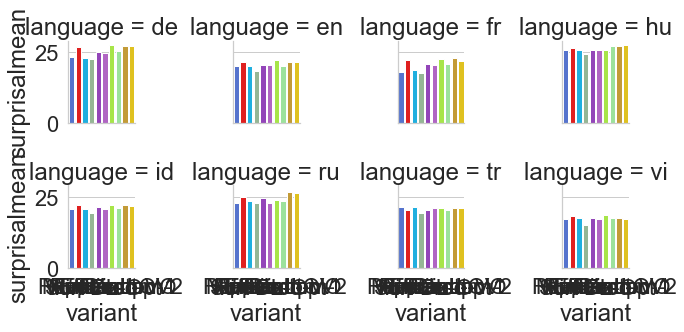

In [267]:
g = sns.FacetGrid(surprisal_variances, col="language", hue="variant", height=2.5, col_wrap=4)
g.map(sns.barplot, "variant", "surprisalmean", order=positions, hue_order=positions, palette=dict(zip(positions, colors)))

In [268]:
df_sub = df.query("language == 'en' & variant == 'Real' & sentence_len >= 10 & sentence_len <= 30").copy()

df_sub["surprisal_var"] = (
    df_sub.groupby(["language", "variant", "document_id", "sentence_id"])
    .surprisal
    .transform(np.var)
)
df_sub

,doc_pos,surprisal,token,document_len,document_id,language,variant,sentence_id,sentence_pos,sentence_len,surprisal_var
12445776,0,5.755079,its,92,0,en,Real,0,0,15,31.382380
12445777,1,5.122285,population,92,0,en,Real,0,1,15,31.382380
12445778,2,9.182750,before,92,0,en,Real,0,2,15,31.382380
12445779,3,7.216791,1995,92,0,en,Real,0,3,15,31.382380
12445780,4,0.568207,was,92,0,en,Real,0,4,15,31.382380
...,...,...,...,...,...,...,...,...,...,...,...
13002056,449,8.302846,republics,471,2139,en,Real,20,24,29,10.869275
13002057,450,1.353864,were,471,2139,en,Real,20,25,29,10.869275
13002058,451,4.510728,set,471,2139,en,Real,20,26,29,10.869275
13002059,452,1.337756,up,471,2139,en,Real,20,27,29,10.869275


In [269]:
examples = (
    df_sub.groupby(["document_id", "sentence_id"])
    .agg({"token": lambda x: " ".join(x), "surprisal_var": "first"})
    .reset_index(drop=True)
)
examples

,token,surprisal_var
0,"its population before 1995 was 77,378 and wa p...",31.382380
1,rubber orange lychee and tea are grown as popp...,28.922989
2,mongmao constituency for people assembly was c...,23.371859
3,paung nap from wa democratic party is elected ...,59.948845
4,the official foundation has been celebrated on...,5.985102
...,...,...
19469,machiavelli later quoted four verses from ital...,9.141973
19470,the peace of westphalia in 1648 formally ended...,12.194397
19471,a sense of italian national identity was refle...,24.002834
19472,it told how a stranger entered a café in milan...,14.770026


In [270]:
examples.nlargest(10,"surprisal_var").token.values

array(['set up in 2008 isfnet harmony ltd. offers employment opportunities in the it sector to people wifjgukhibjmhklj .',
       'roberts was born in rhosllannerchrugog to john and margaret roberts .',
       'naniwa express ナニワエキスプレス was a japanese jazz fusion group active from 1977 to 1986 .',
       'the stilbenolignan aiphanol isorhapontigenin piceatannol and luteolin can be found in the seeds of aiphanes aculeata .',
       'the odai yamamoto i site 大平山元i遺跡 ōdaiyamamoto ichi iseki is a jōmon period archaeological site in sotogahama aomori prefecture japan .',
       'he killed afrasiyab in lake chichast as revenge for siavash who had been killed by aγraēraθa son of naru .',
       'from 2006 to 2009 he has been the president of nuova consonanza www.nuovaconsonanza.it .',
       'the settlement is first mentioned in 1465 as feketehegyház .',
       'he worked with other left wing groups on the evolution of capitalism in the second part of analysis of japanese capitalism 日本資本主義発達史講

In [271]:
examples.nsmallest(10,"surprisal_var").token.values

array(['vacancies in the fiscal officership or on the board of trustees are filled by the remaining trustees .',
       'vacancies in the fiscal officership or on the board of trustees are filled by the remaining trustees .',
       "the place is important in demonstrating the evolution or pattern of queensland 's history .",
       "in april 2019 he was named in new zealand 's squad for the 2019 cricket world cup .",
       'the place is important in demonstrating the principal characteristics of a particular class of cultural places .',
       'he was re elected to the provincial assembly of the punjab as a candidate of pml n from constituency pp 141 lahore v in 2013 pakistani general election .',
       'the song has been performed live on numerous occasions .',
       '2nd brigade 2nd division iv corps to september 1862 .',
       'he served as mayor of brighton in 1923 and 1924 .',
       'in 1960 he was elected as a fellow of the american statistical association .'],
      dtype=

# Surprisal Variance [Doc-initial sents only]

In [272]:
doc_initial_var = (
    df.query("sentence_id == 0")
    .copy()
    .groupby(["language", "variant", "document_id", "sentence_id"])
    .surprisal
    .agg(np.var)
    .dropna()
    .reset_index()
    .groupby(["language", "variant"])
    .agg({"surprisal": [np.mean, sem, np.std]})
    .reset_index()
)
doc_initial_var.columns = doc_initial_var.columns.get_level_values(0) + doc_initial_var.columns.get_level_values(1)
doc_initial_var.to_csv(f"{DATA_DIR}/doc_initial_var.csv", index=False)
doc_initial_var

,language,variant,surprisalmean,surprisalsem,surprisalstd
0,de,Approx,40.315571,0.697730,36.449286
1,de,Efficient-OV,44.964352,0.742744,38.800823
2,de,Efficient-VO,41.734196,0.682741,35.666282
3,de,FREQ_OPT,39.467319,0.689578,36.023421
4,de,Min-DL-Loc,42.261227,0.705541,36.857359
...,...,...,...,...,...
91,vi,Random-2,29.964449,0.970188,44.226106
92,vi,Real,30.015663,0.947961,43.212871
93,vi,Reverse,30.772135,0.910762,41.467184
94,vi,Sort-Freq,25.548380,0.843342,38.397561


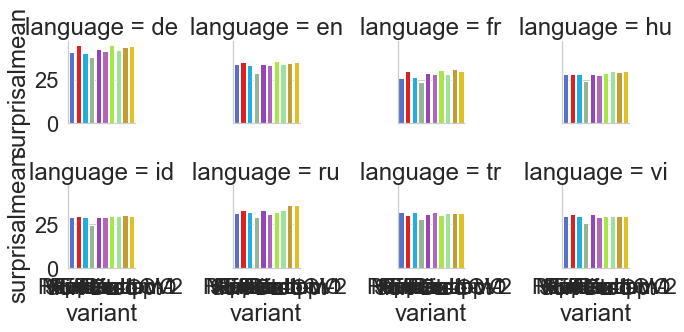

In [273]:
g = sns.FacetGrid(doc_initial_var, col="language", hue="variant", height=2.5, col_wrap=4)
g.map(sns.barplot, "variant", "surprisalmean", order=positions, hue_order=positions, palette=dict(zip(positions, colors)))

# Surprisal Deviation from Dataset Mean

In [274]:
df["surp_diff_squared"] = (df.surprisal - df.groupby(["language", "variant"]).surprisal.transform("mean")) ** 2
surprisal_deviations = (
    df.groupby(["language", "variant", "document_id", "sentence_id"])
    .surp_diff_squared
    .agg("mean")
    .dropna()
    .reset_index()
    .groupby(["language", "variant"])
    .agg({"surp_diff_squared": [np.mean, sem, np.std]})
    .reset_index()                                   
)
surprisal_deviations.columns = surprisal_deviations.columns.get_level_values(0) + surprisal_deviations.columns.get_level_values(1)
surprisal_deviations.to_csv(f"{DATA_DIR}/surprisal_deviations_plot_vals.csv", index=False)
surprisal_deviations

,language,variant,surp_diff_squaredmean,surp_diff_squaredsem,surp_diff_squaredstd
0,de,Approx,24.739511,0.138326,26.596695
1,de,Efficient-OV,28.765329,0.137714,26.479053
2,de,Efficient-VO,26.875286,0.137410,26.420653
3,de,FREQ_OPT,25.439407,0.138410,26.612841
4,de,Min-DL-Loc,26.568850,0.134947,25.947093
...,...,...,...,...,...
91,vi,Random-2,19.368279,0.281242,39.840212
92,vi,Real,19.134497,0.282265,39.982140
93,vi,Reverse,20.287676,0.308842,43.752200
94,vi,Sort-Freq,16.769850,0.290344,41.131592


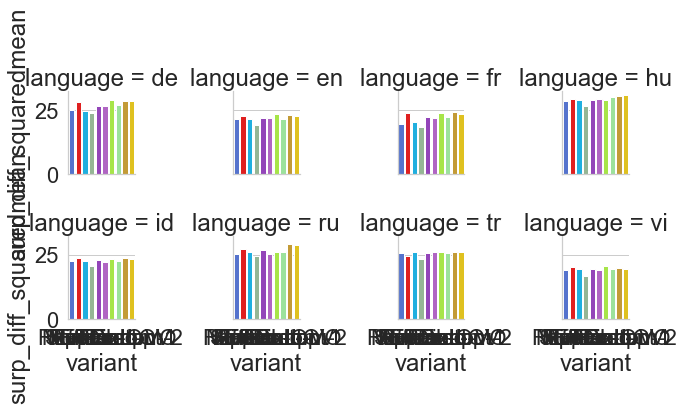

In [275]:
g = sns.FacetGrid(surprisal_deviations, col="language", hue="variant", height=2.5, col_wrap=4)
g.map(sns.barplot, "variant", "surp_diff_squaredmean", order=positions, hue_order=positions, palette=dict(zip(positions, colors)))

# Avg Token-to-Token Change in Surprisal

In [276]:
df["delta_surp"] = abs(df.surprisal - df.surprisal.shift(1))
mask = (df.sentence_pos == 0) & (df.sentence_id == 0)
df.delta_surp[mask] = np.nan
delta_surps = (
    df.dropna(subset=["delta_surp"])
    .groupby(["language", "variant", "document_id", "sentence_id"])
    .agg({"delta_surp": np.mean})
    .dropna()
    .reset_index()
    .groupby(["language", "variant"])
    .agg({"delta_surp": [np.mean, sem, np.std]})
    .reset_index()                                   
)
delta_surps.columns = delta_surps.columns.get_level_values(0) + delta_surps.columns.get_level_values(1)
delta_surps

<ipython-input-276-66c8c9f9f548>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.delta_surp[mask] = np.nan


,language,variant,delta_surpmean,delta_surpsem,delta_surpstd
0,de,Approx,4.590801,0.010635,2.044835
1,de,Efficient-OV,5.427948,0.010468,2.012651
2,de,Efficient-VO,5.032986,0.010755,2.067939
3,de,FREQ_OPT,4.594848,0.010487,2.016439
4,de,Min-DL-Loc,5.076744,0.010503,2.019539
...,...,...,...,...,...
91,vi,Random-2,3.785789,0.015357,2.175477
92,vi,Real,3.856428,0.014953,2.118029
93,vi,Reverse,4.069346,0.015820,2.240922
94,vi,Sort-Freq,2.929903,0.015654,2.217416


In [277]:
delta_surps.to_csv(f"{DATA_DIR}/delta_surps_plot_vals.csv", index=False)

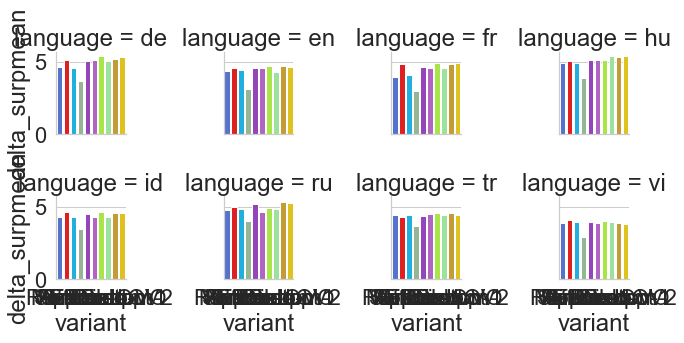

In [278]:
g = sns.FacetGrid(delta_surps, col="language", hue="variant", height=2.5, col_wrap=4)
g.map(sns.barplot, "variant", "delta_surpmean", order=positions, hue_order=positions, palette=dict(zip(positions, colors)))

# Super-Linear Inf

In [279]:
k=1.1
infs_1_1 = (
    df.groupby(["language", "variant", "document_id", "sentence_id"])
    .agg({"surprisal": lambda x: ((x ** k).sum()) ** (1/k)})
    .dropna()
    .reset_index()
    .groupby(["language", "variant"])
    .agg({"surprisal": [np.mean, sem, np.std]})
    .reset_index()                                   
)
infs_1_1.columns = infs_1_1.columns.get_level_values(0) + infs_1_1.columns.get_level_values(1)
infs_1_1

,language,variant,surprisalmean,surprisalsem,surprisalstd
0,de,Approx,73.848802,0.243747,46.866729
1,de,Efficient-OV,76.241039,0.249471,47.967308
2,de,Efficient-VO,75.378522,0.249185,47.912295
3,de,FREQ_OPT,76.844686,0.254197,48.875894
4,de,Min-DL-Loc,79.340922,0.258330,49.670566
...,...,...,...,...,...
91,vi,Random-2,92.469272,0.436943,61.896512
92,vi,Real,72.426654,0.362649,51.368364
93,vi,Reverse,73.803134,0.366955,51.984695
94,vi,Sort-Freq,69.730865,0.305515,43.280819


In [280]:
k=1.25
infs = (
    df.groupby(["language", "variant", "document_id", "sentence_id"])
    .agg({"surprisal": lambda x: ((x ** k).sum()) ** (1/k)})
    .dropna()
    .reset_index()
    .groupby(["language", "variant"])
    .agg({"surprisal": [np.mean, sem, np.std]})
    .reset_index()                                   
)
infs.columns = infs.columns.get_level_values(0) + infs.columns.get_level_values(1)
infs

,language,variant,surprisalmean,surprisalsem,surprisalstd
0,de,Approx,55.690043,0.167084,32.126250
1,de,Efficient-OV,58.009001,0.171293,32.935448
2,de,Efficient-VO,57.086884,0.171274,32.931904
3,de,FREQ_OPT,57.830661,0.173359,33.332792
4,de,Min-DL-Loc,59.791110,0.176056,33.851281
...,...,...,...,...,...
91,vi,Random-2,66.531991,0.282341,39.995942
92,vi,Real,53.224040,0.239736,33.958005
93,vi,Reverse,54.368329,0.243029,34.428683
94,vi,Sort-Freq,50.816796,0.201546,28.551985


In [281]:
infs.to_csv(f"{DATA_DIR}/infs_plot_vals.csv", index=False)

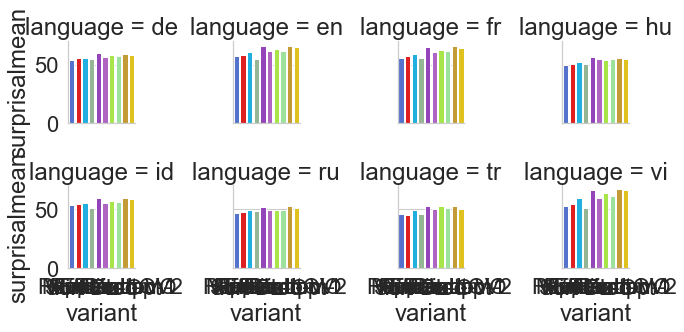

In [282]:
g = sns.FacetGrid(infs, col="language", hue="variant", height=2.5, col_wrap=4)
g.map(sns.barplot, "variant", "surprisalmean", order=positions, hue_order=positions, palette=dict(zip(positions, colors)))

In [283]:
infs_1_1.to_csv(f"{DATA_DIR}/infs_1.1_plot_vals.csv", index=False)

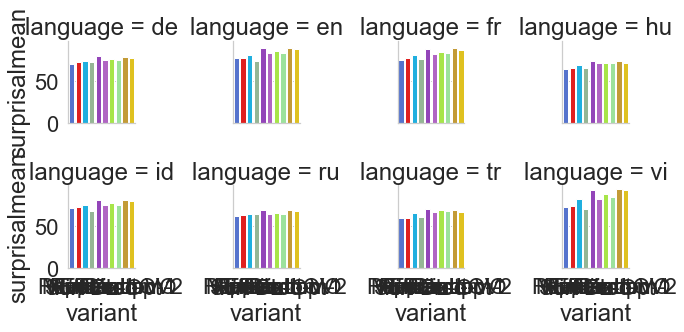

In [284]:
g = sns.FacetGrid(infs_1_1, col="language", hue="variant", height=2.5, col_wrap=4)
g.map(sns.barplot, "variant", "surprisalmean", order=positions, hue_order=positions, palette=dict(zip(positions, colors)))

# Average Surprisal by Token Position

In [285]:
avg_surps = (
    df.query("sentence_len <= 20 & sentence_len >= 10")
    .copy()
    .groupby(["language", "variant", "sentence_len", "sentence_pos"])
    .agg({"surprisal": [np.mean, sem, np.std]})
    .dropna()
    .reset_index()
)
avg_surps.columns = avg_surps.columns.get_level_values(0) + avg_surps.columns.get_level_values(1)
avg_surps

,language,variant,sentence_len,sentence_pos,surprisalmean,surprisalsem,surprisalstd
0,de,Approx,10,0,3.902059,0.088768,3.830419
1,de,Approx,10,1,5.201975,0.113612,4.902472
2,de,Approx,10,2,5.604562,0.115970,5.004212
3,de,Approx,10,3,5.295741,0.112064,4.835664
4,de,Approx,10,4,5.092104,0.104170,4.495040
...,...,...,...,...,...,...,...
15835,vi,Sort-Freq-Rev,20,15,2.403814,0.070228,1.789094
15836,vi,Sort-Freq-Rev,20,16,2.208429,0.061681,1.571346
15837,vi,Sort-Freq-Rev,20,17,1.986024,0.060359,1.537677
15838,vi,Sort-Freq-Rev,20,18,1.876184,0.053736,1.368963


In [286]:
avg_surps.to_csv(f"{DATA_DIR}/avg_surps_plot_vals.csv", index=False)

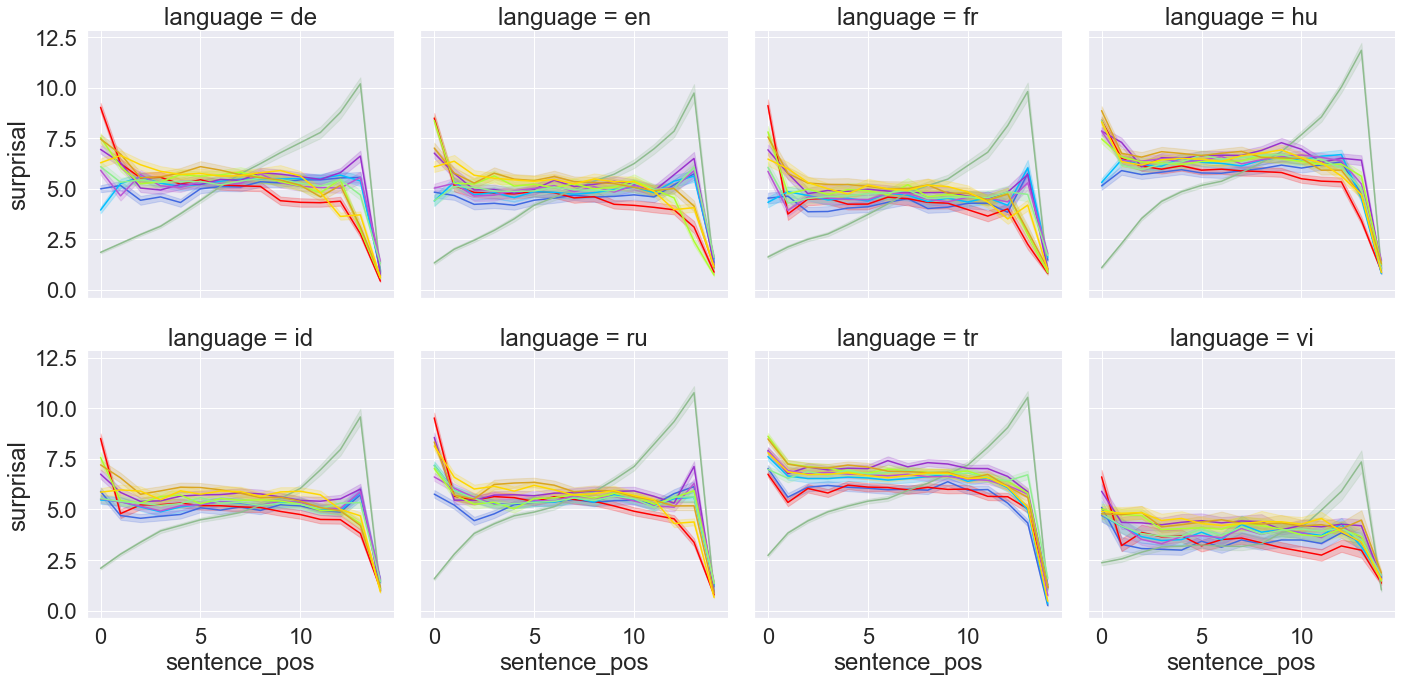

In [287]:
sns.set(font_scale=2)
g = sns.FacetGrid(df.query("sentence_len == 15"), col="language", hue="variant", height=5, col_wrap=4,
                  hue_order=positions, palette=dict(zip(positions, colors)))
g.map(sns.lineplot, "sentence_pos", "surprisal", markers=True)

# Delta Surprisal - Token Plot

In [288]:
df["delta_surp"] = abs(df.surprisal - df.surprisal.shift(1))
df.delta_surp.loc[(df.sentence_pos == 0) & (df.sentence_id == 0)] = np.nan
delta_surps_by_tok = (
    df.dropna(subset=["delta_surp"])
    .groupby(["language", "variant", "sentence_len", "sentence_pos"])
    .agg({"delta_surp": [np.mean, sem, np.std]})
    .dropna()
    .reset_index()                              
)
delta_surps_by_tok.columns = delta_surps_by_tok.columns.get_level_values(0) + delta_surps_by_tok.columns.get_level_values(1)
delta_surps_by_tok

<ipython-input-288-e792925faf74>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.delta_surp.loc[(df.sentence_pos == 0) & (df.sentence_id == 0)] = np.nan
/Users/thomasclark/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/thomasclark/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


,language,variant,sentence_len,sentence_pos,delta_surpmean,delta_surpsem,delta_surpstd
0,de,Approx,2,0,7.970613,0.574783,7.016123
1,de,Approx,2,1,7.577097,0.536548,6.658389
2,de,Approx,3,0,6.916735,0.503063,6.363302
3,de,Approx,3,1,6.829518,0.407833,6.007755
4,de,Approx,3,2,7.843465,0.443238,6.529298
...,...,...,...,...,...,...,...
365365,vi,Sort-Freq-Rev,124,119,0.127493,0.019900,0.028142
365366,vi,Sort-Freq-Rev,124,120,0.653412,0.207382,0.293283
365367,vi,Sort-Freq-Rev,124,121,0.764140,0.199546,0.282201
365368,vi,Sort-Freq-Rev,124,122,0.587150,0.432513,0.611665


In [289]:
delta_surps_by_tok.query("sentence_len == 15 & language == 'en' & variant == 'Real'")

,language,variant,sentence_len,sentence_pos,delta_surpmean,delta_surpsem,delta_surpstd
67220,en,Real,15,0,3.337483,0.127288,4.179232
67221,en,Real,15,1,4.122875,0.123176,4.213284
67222,en,Real,15,2,3.868108,0.113590,3.885391
67223,en,Real,15,3,4.037130,0.125930,4.307458
67224,en,Real,15,4,4.040539,0.108859,3.723555
67225,en,Real,15,5,3.892662,0.101118,3.458774
67226,en,Real,15,6,4.015481,0.112209,3.838127
67227,en,Real,15,7,4.268458,0.121513,4.156373
67228,en,Real,15,8,4.120038,0.118535,4.054520
67229,en,Real,15,9,4.105884,0.126774,4.336337


In [290]:
(delta_surps_by_tok
 .query("sentence_len >= 10 & sentence_len <= 20")
 .to_csv(f"{DATA_DIR}/delta_surps_by_tok.csv", index=False))

# Max Surprisal

In [291]:
max_surps = (
    df.groupby(["language", "variant", "document_id", "sentence_id"])
    .surprisal
    .agg("max")
    .dropna()
    .reset_index()
    .groupby(["language", "variant"])
    .agg({"surprisal": [np.mean, sem, np.std]})
    .reset_index()                                   
)
max_surps.columns = max_surps.columns.get_level_values(0) + max_surps.columns.get_level_values(1)
max_surps.to_csv(f"{DATA_DIR}/max_surps_plot_vals.csv", index=False)
max_surps

,language,variant,surprisalmean,surprisalsem,surprisalstd
0,de,Approx,16.040936,0.040357,7.759702
1,de,Efficient-OV,16.843437,0.039408,7.577170
2,de,Efficient-VO,16.452953,0.040415,7.770911
3,de,FREQ_OPT,16.325819,0.040304,7.749426
4,de,Min-DL-Loc,16.671406,0.039981,7.687304
...,...,...,...,...,...
91,vi,Random-2,14.067805,0.056616,8.020158
92,vi,Real,13.266446,0.056256,7.968454
93,vi,Reverse,13.655616,0.057067,8.084426
94,vi,Sort-Freq,12.803061,0.055964,7.928211


In [227]:
import os
os.system("Rscript tacl_plots.R")

256